In [1]:
!nvidia-smi

Tue Oct 29 19:12:52 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   44C    P0    54W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, time
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Image Augmenters
from albumentations import (Compose, HorizontalFlip, Cutout, PadIfNeeded, RandomCrop)

from clr import OneCycleLR

In [3]:
zip_file = tf.keras.utils.get_file(origin="https://s3.amazonaws.com/fast-ai-imageclas/imagenette-320.tgz",
                                   fname="imagenette-320.tgz", extract=True)
base_dir, _ = os.path.splitext(zip_file)

In [4]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [5]:
image_size = 224 # All images will be resized to 224x224
batch_size = 32

def CustomImageDataGen(input_img):
    seq = Compose([PadIfNeeded(232,232, p=1),
                   RandomCrop(224,224, p=1),
                   HorizontalFlip(p=0.5),
                   Cutout(num_holes=1, max_h_size=56, max_w_size=56, p=0.5)
                  ], p=1)
    output_img = seq(image = input_img)['image']
    return output_img

# Rescale all images by 1./255 and apply image augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                preprocessing_function=CustomImageDataGen)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='categorical')

Found 12894 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [6]:
IMG_SHAPE = (image_size, image_size, 3)
from tensorflow.keras.applications.resnet50 import ResNet50
import resnet50

# Create the base model of Resnet50 with original BatchNorm
base_model_orig = ResNet50(input_shape=IMG_SHAPE,
                                include_top=False,
                                weights=None)

# Create the base model of Resnet50 with modified BatchNorm
base_model_mod = resnet50.ResNet50(input_shape= IMG_SHAPE,
                                   include_top=False,
                                   weights=None)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
W1029 19:13:16.334483 140156441913152 deprecation.py:506] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
/home/ec2-user/Imagenette/resnet50.py:270: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [7]:
# Let's take a look at the base model architecture with original batchnorm
base_model_orig.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [8]:
# Let's take a look at the base model architecture with modified batchnorm
base_model_mod.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, 112, 112, 64) 128         conv1[0][0]                      
___________________________________________________________________________________________

In [7]:
model_orig = tf.keras.Sequential([
  base_model_orig,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10, activation='softmax')
])

model_mod = tf.keras.Sequential([
  base_model_mod,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [8]:
# Original
model_orig.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-02, momentum=0.9, nesterov=True),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Modified
model_mod.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-02, momentum=0.9, nesterov=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# Original Batchnorm

lr_manager = OneCycleLR(max_lr= 1e-02, maximum_momentum=0.9, verbose=False)

from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint("best_orig.h5", monitor='val_acc', verbose=0, save_best_only=True)

epochs = 50
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

start = time.time()
history_orig = model_orig.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              callbacks=[lr_manager, checkpointer],
                              verbose=2)
end = time.time()
print('Resnet50 with orignal batchnorm took time to train', (end-start),'s')

Epoch 1/50


W1029 17:03:34.839107 140719948220224 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.280865). Check your callbacks.


402/402 - 88s - loss: 2.1329 - acc: 0.2399 - val_loss: 3.4111 - val_acc: 0.2417
Epoch 2/50
402/402 - 68s - loss: 1.7905 - acc: 0.3921 - val_loss: 3.8118 - val_acc: 0.2396
Epoch 3/50
402/402 - 69s - loss: 1.5664 - acc: 0.4789 - val_loss: 1.8029 - val_acc: 0.4437
Epoch 4/50
402/402 - 69s - loss: 1.3981 - acc: 0.5498 - val_loss: 2.0652 - val_acc: 0.3854
Epoch 5/50
402/402 - 69s - loss: 1.2161 - acc: 0.6101 - val_loss: 1.4818 - val_acc: 0.5375
Epoch 6/50
402/402 - 69s - loss: 1.1327 - acc: 0.6438 - val_loss: 1.6607 - val_acc: 0.5688
Epoch 7/50
402/402 - 68s - loss: 1.0125 - acc: 0.6805 - val_loss: 2.1700 - val_acc: 0.4958
Epoch 8/50
402/402 - 70s - loss: 0.9571 - acc: 0.7032 - val_loss: 1.1469 - val_acc: 0.6812
Epoch 9/50
402/402 - 68s - loss: 0.8765 - acc: 0.7283 - val_loss: 1.6251 - val_acc: 0.5875
Epoch 10/50
402/402 - 69s - loss: 0.8224 - acc: 0.7448 - val_loss: 1.2316 - val_acc: 0.6229
Epoch 11/50
402/402 - 69s - loss: 0.7640 - acc: 0.7631 - val_loss: 1.1673 - val_acc: 0.6958
Epoch 12

In [9]:
#Modified Batchnorm

lr_manager = OneCycleLR(max_lr= 1e-02, maximum_momentum=0.9,  verbose=False)
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint("best_mod.h5", monitor='val_acc', verbose=0, save_best_only=True)

epochs = 50
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

start = time.time()
history_mod = model_mod.fit_generator(train_generator,
                                      steps_per_epoch = steps_per_epoch,
                                      epochs=epochs,
                                      workers=4,
                                      validation_data=validation_generator,
                                      validation_steps=validation_steps,
                                      callbacks=[lr_manager, checkpointer],
                                      verbose=2)
end = time.time()
print('Resnet50 with modified batchnorm took time to train', (end-start),'s')

Epoch 1/50


W1029 19:14:11.896446 140156441913152 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.360087). Check your callbacks.


402/402 - 124s - loss: 2.1451 - acc: 0.2430 - val_loss: 7.7492 - val_acc: 0.1917
Epoch 2/50
402/402 - 99s - loss: 1.8145 - acc: 0.3836 - val_loss: 1.8986 - val_acc: 0.3979
Epoch 3/50
402/402 - 99s - loss: 1.5865 - acc: 0.4754 - val_loss: 2.0136 - val_acc: 0.4062
Epoch 4/50
402/402 - 98s - loss: 1.3819 - acc: 0.5532 - val_loss: 1.7936 - val_acc: 0.4979
Epoch 5/50
402/402 - 98s - loss: 1.2244 - acc: 0.6118 - val_loss: 1.4753 - val_acc: 0.5562
Epoch 6/50
402/402 - 98s - loss: 1.0950 - acc: 0.6512 - val_loss: 5.3779 - val_acc: 0.2208
Epoch 7/50
402/402 - 98s - loss: 1.0008 - acc: 0.6836 - val_loss: 1.2735 - val_acc: 0.6271
Epoch 8/50
402/402 - 98s - loss: 0.9167 - acc: 0.7087 - val_loss: 1.4805 - val_acc: 0.6167
Epoch 9/50
402/402 - 98s - loss: 0.8529 - acc: 0.7302 - val_loss: 3.0067 - val_acc: 0.3771
Epoch 10/50
402/402 - 98s - loss: 0.8061 - acc: 0.7456 - val_loss: 1.8289 - val_acc: 0.5542
Epoch 11/50
402/402 - 98s - loss: 0.7674 - acc: 0.7602 - val_loss: 1.1139 - val_acc: 0.6604
Epoch 1

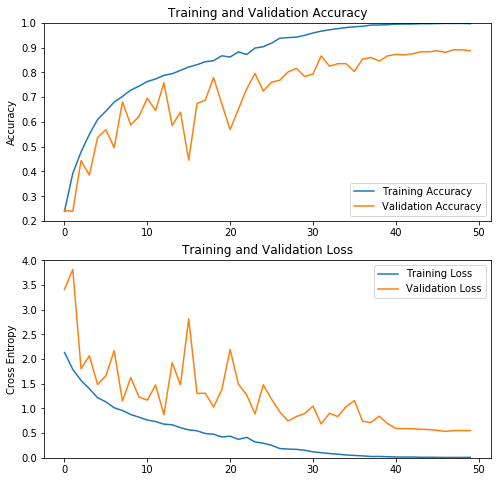

In [13]:
acc = history_orig.history['acc']
val_acc = history_orig.history['val_acc']

loss = history_orig.history['loss']
val_loss = history_orig.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

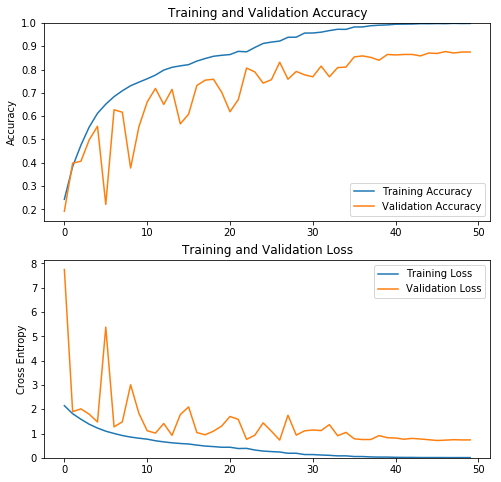

In [11]:
acc = history_mod.history['acc']
val_acc = history_mod.history['val_acc']

loss = history_mod.history['loss']
val_loss = history_mod.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [15]:
# load the model with original batchnorm
from tensorflow.keras.models import load_model
bestmodel = load_model("best_orig.h5")

# Evaluation
score= bestmodel.evaluate_generator(validation_generator, steps=validation_steps, verbose=0)
print("Minimal Validation Loss : ", score[0])
print("Max Validation Accuracy:", score[1]*100, "%")

W1029 19:10:58.836652 140719948220224 deprecation.py:506] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1029 19:10:58.838619 140719948220224 deprecation.py:506] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1029 19:11:05.935414 140719948220224 deprecation.py:506] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_

Minimal Validation Loss :  0.5500532115499178
Max Validation Accuracy: 89.16666507720947 %


In [12]:
# load the model with modified batchnorm
from batchnorm import BatchNorm
from tensorflow.keras.models import load_model
bestmodel2 = load_model("best_mod.h5", custom_objects={'BatchNorm': BatchNorm})

# Evaluation
score= bestmodel2.evaluate_generator(validation_generator, steps=validation_steps, verbose=0)
print("Minimal Validation Loss : ", score[0])
print("Max Validation Accuracy:", score[1]*100, "%")

W1029 20:36:54.834867 140156441913152 deprecation.py:506] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1029 20:36:54.836875 140156441913152 deprecation.py:506] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1029 20:37:05.610885 140156441913152 deprecation.py:506] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_

Minimal Validation Loss :  0.7270948201417923
Max Validation Accuracy: 87.70833611488342 %
